In [1]:
import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
df             = pd.read_csv("Prepared_Dataset_By_VASU_N2.csv", index_col=0)
X_chi2_best      = pd.read_csv("X_chi2_best.csv", index_col=0)
X_best_mi_scores = pd.read_csv("X_best_mi_scores.csv", index_col=0)
X_pca_final      = pd.read_csv("X_pca_final_by_vasu.csv", index_col=0)
X_best_features  = pd.read_csv("X_best_features.csv", index_col=0)

In [5]:
y=df['EverDelinquent']

In [6]:
y.value_counts()

EverDelinquent
0    233787
1     57662
Name: count, dtype: int64

In [7]:
X_best_features.shape

(291449, 14)

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X_best_features,y,test_size=0.3,random_state=42)

In [45]:
X_train.shape

(204014, 14)

In [46]:
X_test.shape

(87435, 14)

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
dtc=DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=42)

In [49]:
dtc.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [51]:
y_pred_dt=dtc.predict(X_test)

In [52]:
print('Model accuracy score with criterion entropy: {0:0.4f}'.format(accuracy_score(y_test, y_pred_dt)))

Model accuracy score with criterion entropy: 0.8124


In [53]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     70033
           1       0.63      0.14      0.23     17402

    accuracy                           0.81     87435
   macro avg       0.73      0.56      0.56     87435
weighted avg       0.78      0.81      0.76     87435



In [54]:
cm = confusion_matrix(y_test, y_pred_dt)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[68606  1427]
 [14973  2429]]


In [55]:

import xgboost as xgb
from xgboost import XGBClassifier

In [56]:
data_dmatrix = xgb.DMatrix(data=X_best_features, label=y)

In [57]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 0.01,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [58]:
print(xgb_clf)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


In [59]:
y_pred_xgb = xgb_clf.predict(X_test)

In [60]:
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_xgb)))

XGBoost model accuracy score: 0.8053


In [61]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.01,
                'max_depth': 7, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [62]:
import matplotlib.pyplot as plt

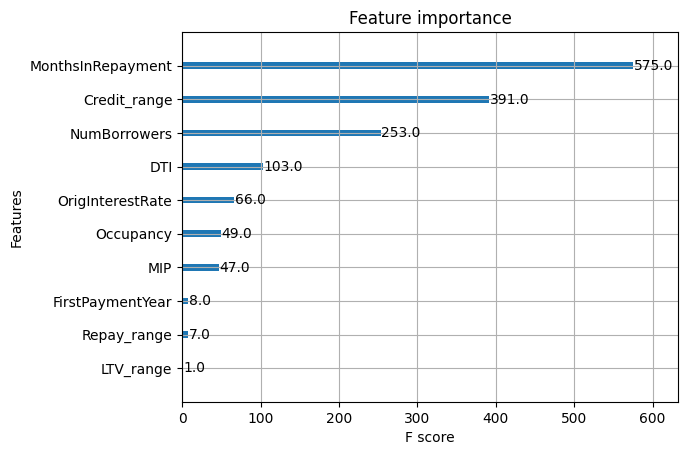

<Figure size 1600x1200 with 0 Axes>

In [63]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

In [65]:
import optuna
from optuna import create_study
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [66]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',  # Logarithmic loss for binary classification
        'verbosity': 0,
        'n_jobs': -1,  # Use all available CPU cores
        'seed': 42,
        'tree_method': 'hist',  # You can try different tree methods
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),  # Adjust this parameter for class imbalance
   
        #'n_estimators': 180,
    }

    # Create the XGBoost model
    model = XGBClassifier(**params)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy as the metric to optimize
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [67]:
study = optuna.create_study(direction='maximize')

# Perform hyperparameter optimization
n_trials = 100  # You can adjust the number of trials
study.optimize(objective, n_trials=n_trials)

[I 2024-02-19 00:17:49,408] A new study created in memory with name: no-name-963f08a3-ed4d-4f6b-8e83-f404bf11032d
[I 2024-02-19 00:17:54,698] Trial 0 finished with value: 0.2158289014696632 and parameters: {'learning_rate': 0.0050382645537392886, 'max_depth': 8, 'min_child_weight': 0.00024286763816659272, 'subsample': 0.6545746950147782, 'colsample_bytree': 0.9988225390331169, 'gamma': 9.741622604798337e-05, 'reg_alpha': 3.8163889224179256e-05, 'reg_lambda': 0.010309685892444263, 'scale_pos_weight': 9.794392274487082}. Best is trial 0 with value: 0.2158289014696632.
[I 2024-02-19 00:17:58,728] Trial 1 finished with value: 0.19902784925944988 and parameters: {'learning_rate': 0.0015978970842497433, 'max_depth': 5, 'min_child_weight': 0.9314303301608001, 'subsample': 0.5805838072771775, 'colsample_bytree': 0.7912908179509031, 'gamma': 0.1334885143331427, 'reg_alpha': 0.7575453371742775, 'reg_lambda': 0.01808305823589051, 'scale_pos_weight': 5.6617622752594485}. Best is trial 0 with value

In [68]:
best_trial = study.best_trial
print(f"Best trial - Accuracy: {best_trial.value:.4f}")
print("Best trial - Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best trial - Accuracy: 0.8138
Best trial - Params: 
    learning_rate: 0.01599902883786509
    max_depth: 9
    min_child_weight: 2.2139566086435263
    subsample: 0.6514782081696445
    colsample_bytree: 0.8135881431305896
    gamma: 0.26446406004357736
    reg_alpha: 1.9365311156636174e-05
    reg_lambda: 0.011592820966233796
    scale_pos_weight: 1.3052488423066926


In [69]:
best_params = best_trial.params
best_model = xgb.XGBClassifier(**best_params)

In [71]:
from sklearn.model_selection import StratifiedKFold

In [72]:
n_splits = 5  # Adjust as needed

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store cross-validation scores
accuracy_scores = []

# Perform cross-validation
for train_idx, val_idx in kf.split(X_best_features, y):
    X_train, X_val = X_best_features.iloc[train_idx], X_best_features.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create and train the XGBoost model with the best hyperparameters
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)
    print("Accuracy", accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy (StratifiedKFold): {mean_accuracy:.4f}")

Accuracy 0.8140675930691371
Accuracy 0.8128838565791731
Accuracy 0.8152684851604048
Accuracy 0.8137416366443644
Accuracy 0.814235962188406
Mean Accuracy (StratifiedKFold): 0.8140
